<a href="https://colab.research.google.com/github/mipypf/practical-mi-guide/blob/develop/chapter5/src/bayesian_optimizaition_sample_proof%20stress.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# リストベースアプローチとベイズ最適化を組み合わせた有望な実験条件候補の探索を行う
### 使用するデータセットの参考文献
 - Tamura, R. et al. Materials informatics approach to understand aluminum alloys. Sci Technol Adv Mater 540–551 (2020) doi:10.1080/14686996.2020.1791676

## データセットのダウンロード
 - https://www.tandfonline.com/doi/full/10.1080/14686996.2020.1791676#supplemental-material-section からtsta_a_1791676_sm7407.csvをダウンロード

## Google Colabの準備

In [1]:
# Google Colabを利用する場合はTrue、そうでない場合はFalseとする
colab = True

In [2]:
# Google Colabのファイルをクリックし、tsta_a_1791676_sm7407.csvをドラッグ＆ドロップしてアップロード
if colab:
  INPUT_FILE_PATH = "./"
  OUTPUT_FILE_PATH = "./"
else:
  INPUT_FILE_PATH = "../input/"
  OUTPUT_FILE_PATH = "../output/"

## ライブラリをインポート

In [3]:
! pip install scikit-learn==1.3.2
! pip install numpy==1.26.4
! pip install pandas==2.2.2
! pip install scipy==1.13.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 88.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


In [4]:
import warnings

warnings.filterwarnings("ignore")

import dataclasses
import pickle
import random
import time
from typing import List, Union

import matplotlib.font_manager as font_manager
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm
from sklearn import preprocessing
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold
from sklearn.utils import check_array, check_X_y

## グラフ表示の際のフォントサイズを設定

In [5]:
plt.rcParams["font.size"] = 15
plt.rcParams["axes.labelsize"] = 15
plt.rcParams["xtick.labelsize"] = 15
plt.rcParams["ytick.labelsize"] = 15
plt.rcParams["axes.titlesize"] = 15

## データを読み込み、データフレームに格納

In [9]:
data = pd.read_csv(INPUT_FILE_PATH + "tsta_a_1791676_sm7407.csv")
data

,ID,X,n,Fe (wt%),Mn (wt%),Si (wt%),Al (wt%),Mg (wt%),Ti (wt%),Cu (wt%),Cr (wt%),Zn (wt%),2% proof stress (Mpa),Tensile strength (Mpa),Elongation (%)
0,A 5005 P,1,2,0.35,0.1,0.15,98.33,0.8,0.0,0.1,0.05,0.125,95,125,2
1,A 5005 P,1,4,0.35,0.1,0.15,98.33,0.8,0.0,0.1,0.05,0.125,120,145,2
2,A 5005 P,1,6,0.35,0.1,0.15,98.33,0.8,0.0,0.1,0.05,0.125,145,165,2
3,A 5005 P,1,8,0.35,0.1,0.15,98.33,0.8,0.0,0.1,0.05,0.125,165,185,2
4,A 5005 P,2,2,0.35,0.1,0.15,98.33,0.8,0.0,0.1,0.05,0.125,85,120,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,A 5N01 P,1,4,0.13,0.1,0.08,99.19,0.4,0.0,0.1,0.00,0.015,115,125,3
111,A 5N01 P,1,6,0.13,0.1,0.08,99.19,0.4,0.0,0.1,0.00,0.015,135,145,2
112,A 5N01 P,3,2,0.13,0.1,0.08,99.19,0.4,0.0,0.1,0.00,0.015,85,120,4
113,A 5N01 P,3,4,0.13,0.1,0.08,99.19,0.4,0.0,0.1,0.00,0.015,105,140,3


## 有望な実験条件候補の探索を行うための準備

In [10]:
# 不必要な列を削除
drop_columns = ["ID", "Elongation (%)", "Tensile strength (Mpa)"]
data = data.drop(drop_columns, axis=1)

# 列名をそれぞれ定義
x_columns = list(data.columns[:-1])  # 特徴量の列名
y_columns = list(data.columns[-1:])  # 目的変数の列名

# 重複するデータを平均値でまとめる
data = data.groupby(x_columns)[y_columns].agg(lambda x: x.unique().mean()).reset_index()

# 今回の目的変数である2% proof stress (Mpa)の大きい順に並び変えて上位20件を表示
data.sort_values(by=y_columns, ascending=False).head(20)

,X,n,Fe (wt%),Mn (wt%),Si (wt%),Al (wt%),Mg (wt%),Ti (wt%),Cu (wt%),Cr (wt%),Zn (wt%),2% proof stress (Mpa)
40,1,8,0.20,0.13,0.15,94.25,5.05,0.00,0.05,0.13,0.050,360.0
107,3,8,0.20,0.13,0.15,94.25,5.05,0.00,0.05,0.13,0.050,320.0
47,1,9,0.18,0.35,0.10,94.58,4.50,0.05,0.08,0.05,0.125,320.0
48,1,9,0.18,0.35,0.10,95.58,3.50,0.05,0.08,0.05,0.125,320.0
114,4,8,0.18,0.08,0.10,94.83,4.50,0.05,0.08,0.08,0.125,300.0
36,1,8,0.18,0.35,0.10,95.58,3.50,0.05,0.08,0.05,0.125,300.0
111,3,8,0.25,0.45,0.20,94.70,4.00,0.08,0.05,0.15,0.125,285.0
44,1,8,0.25,0.45,0.20,94.70,4.00,0.08,0.05,0.15,0.125,285.0
89,3,4,0.20,0.13,0.15,94.25,5.05,0.00,0.05,0.13,0.050,265.0
72,2,6,0.25,0.45,0.20,94.70,4.00,0.08,0.05,0.15,0.125,265.0


## 最適化計算の実施

In [75]:
# 獲得関数Expected Improvement(EI)を計算する関数
def calculate_ei(X, model, y_best, xi=0):
    mean, std = model.predict(X, return_std=True)
    z = (mean - y_best - xi) / std
    return (mean - y_best - xi) * norm.cdf(z) + std * norm.pdf(z), mean, std

# ガウス過程回帰モデルを構築する関数
def fit_gaussian_process(X, Y, kernel=None, alpha=0):
    if kernel is None:
        kernel = ConstantKernel() * RBF() + WhiteKernel()
    model = GaussianProcessRegressor(kernel=kernel, alpha=alpha)
    model.fit(X, Y)
    return model

# 学習済モデルを用いて確率分布を出力する関数（予測値と標準偏差を返す）
def predict_distribution(model, X):
    pred_value = model.predict(X, return_std=True)
    return pred_value[0], pred_value[1]

# 次のサンプルを選択する関数
def select_next_sample(ac_values, index_learn_pool):
    max_ac = np.max(ac_values[index_learn_pool])
    candidates = [i for i in index_learn_pool if ac_values[i] == max_ac]
    return random.choice(candidates)

#  Leave-One-Out クロスバリデーションを実行し、実測値と予測値を取得する関数
def leave_one_out_cross_validation(X, Y, model):
    folds = len(X)
    kf = KFold(n_splits=folds)
    scaler_x = preprocessing.StandardScaler()
    scaler_y = preprocessing.StandardScaler()

    Y_actual = []
    Y_predicted = []

    for train_index, valid_index in kf.split(X):
        X_train, X_valid = X[train_index], X[valid_index]
        Y_train, Y_valid = Y[train_index], Y[valid_index]

        # 正規化
        X_train_std = scaler_x.fit_transform(X_train)
        X_valid_std = scaler_x.transform(X_valid)
        Y_train_std = scaler_y.fit_transform(Y_train.reshape(-1, 1)).ravel()

        # モデルを学習
        model.fit(X_train_std, Y_train_std)

        # 予測値を取得し、元スケールに戻す
        Y_valid_pred_std = model.predict(X_valid_std).reshape(-1, 1)
        Y_valid_pred = scaler_y.inverse_transform(Y_valid_pred_std)

        Y_actual.append(Y_valid[0])
        Y_predicted.append(Y_valid_pred[0][0])

    return np.array(Y_actual), np.array(Y_predicted)

# 実測値と予測値の散布図をプロットする関数
def plot_actual_vs_predicted(Y_actual, Y_predicted):
    plt.figure(figsize=(8, 8))
    plt.title("Predicted vs Actual")
    plt.scatter(Y_actual, Y_predicted, label="valid", color="red", marker="*", s=100)
    x_truth = np.arange(Y_actual.min(), Y_actual.max() + 1)
    y_truth = x_truth
    plt.plot(x_truth, y_truth, "--", color="gray", label="truth")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    # plt.textでRMSE, MAE, R2を右下に表示
    plt.text(
        0.6,
        0.3,
        f"RMSE_valid: {np.sqrt(mean_squared_error(Y_actual, Y_predicted)):.2f}",
        transform=plt.gca().transAxes,
    )
    plt.text(
        0.6,
        0.2,
        f"MAE_valid: {mean_absolute_error(Y_actual, Y_predicted):.2f}",
        transform=plt.gca().transAxes,
    )
    plt.text(
        0.6,
        0.1,
        f"R2_valid: {r2_score(Y_actual, Y_predicted):.2f}",
        transform=plt.gca().transAxes,
    )
    plt.legend()
    plt.show()

# ベイズ最適化を行う関数
def optimize_experiment(model, X_all, Y_all, x_columns, y_columns, n_ensemble=5, n_exp_initial=50, xi=0, iterations=-1):

    start_time = time.time()

    all_data_num = X_all.shape[0]
    np.random.seed(0)
    seed_list = [int(x) for x in np.random.randint(0, 10000, n_ensemble)]

    y_best_trend_list = []

    for ensemble_num, seed in enumerate(seed_list):
        print(f"Ensemble {ensemble_num + 1}/{n_ensemble}, Seed: {seed}")
        random.seed(seed)

        # 初期点の設定
        threshold = np.percentile(Y_all, 90)  # 上位10%の閾値
        top_10_percent_indices = np.where(Y_all >= threshold)[0]
        index_all_pool = list(range(all_data_num))
        index_under_pool = [i for i in index_all_pool if i not in top_10_percent_indices]
        index_observed = random.sample(index_under_pool, n_exp_initial)  # 初期点をランダムにサンプリング
        index_learn_pool = [i for i in index_all_pool if i not in index_observed]  # 未実験の候補リスト

        # スケーリング（初期点に基づく）
        x_scaler = preprocessing.StandardScaler()
        y_scaler = preprocessing.StandardScaler()

        x_train_std = x_scaler.fit_transform(X_all[index_observed])
        y_observed_std = y_scaler.fit_transform(Y_all[index_observed].reshape(-1, 1)).ravel()

        # LOOCVのプロット
        print("Performing LOO Cross Validation...")
        Y_actual, Y_predicted = leave_one_out_cross_validation(X_all[index_observed], Y_all[index_observed], model)
        plot_actual_vs_predicted(Y_actual, Y_predicted)

        if iterations == -1:
            iterations = len(index_learn_pool)
        else:
            iterations = min(iterations, len(index_learn_pool))

        y_best_trend = []

        for _ in range(iterations):
            # モデルの学習
            model.fit(x_train_std, y_observed_std)

            # 獲得関数の計算
            ac_values, _, _ = calculate_ei(x_scaler.transform(X_all), model, max(y_observed_std), xi)

            # 次のサンプルを選択
            next_index = select_next_sample(ac_values, index_learn_pool)
            index_observed.append(next_index)  # 実験済みに追加
            index_learn_pool.remove(next_index)  # 未実験リストから削除

            # 現時点での最良値を記録
            y_best_trend.append(np.max(Y_all[index_observed]))

            # サンプルを追加して再スケーリング
            x_train_std = x_scaler.fit_transform(X_all[index_observed])
            y_observed_std = y_scaler.fit_transform(Y_all[index_observed].reshape(-1, 1)).ravel()

        y_best_trend_list.append(y_best_trend)

    print(f"Optimization completed in {time.time() - start_time:.2f} seconds.")
    return y_best_trend_list


Ensemble 1/5, Seed: 2732
Performing LOO Cross Validation...


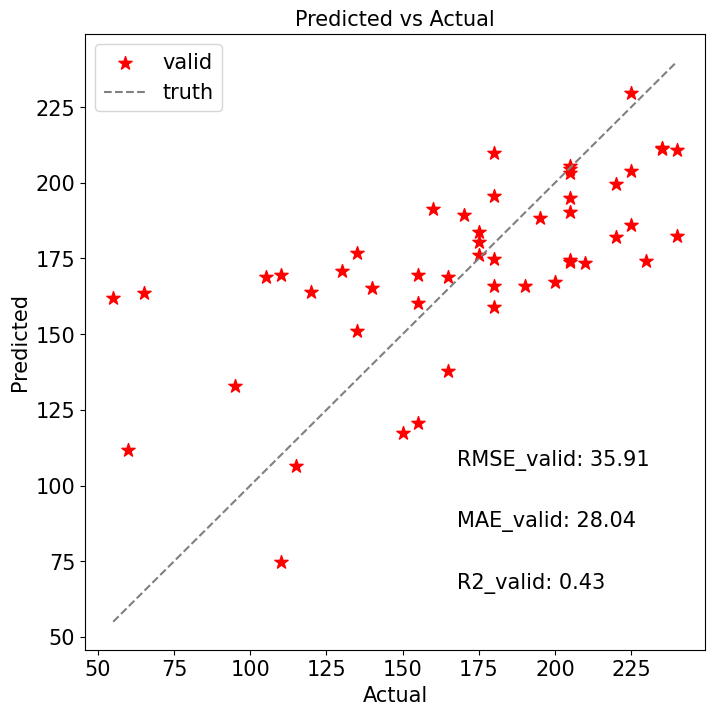

Ensemble 2/5, Seed: 9845
Performing LOO Cross Validation...


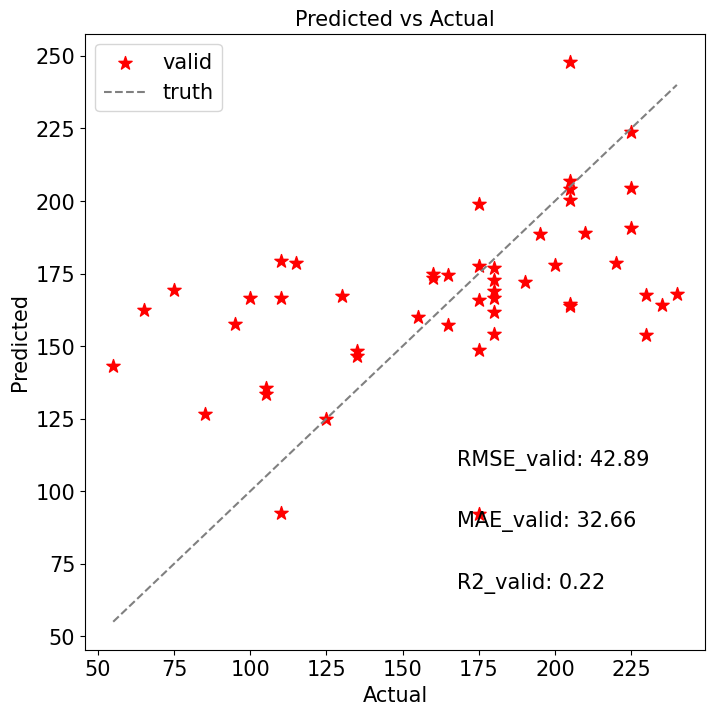

Ensemble 3/5, Seed: 3264
Performing LOO Cross Validation...


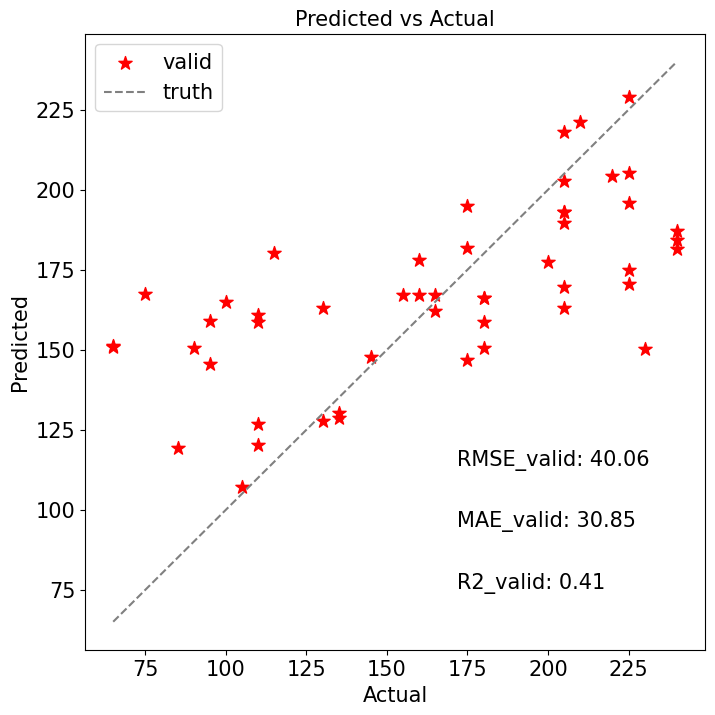

Ensemble 4/5, Seed: 4859
Performing LOO Cross Validation...


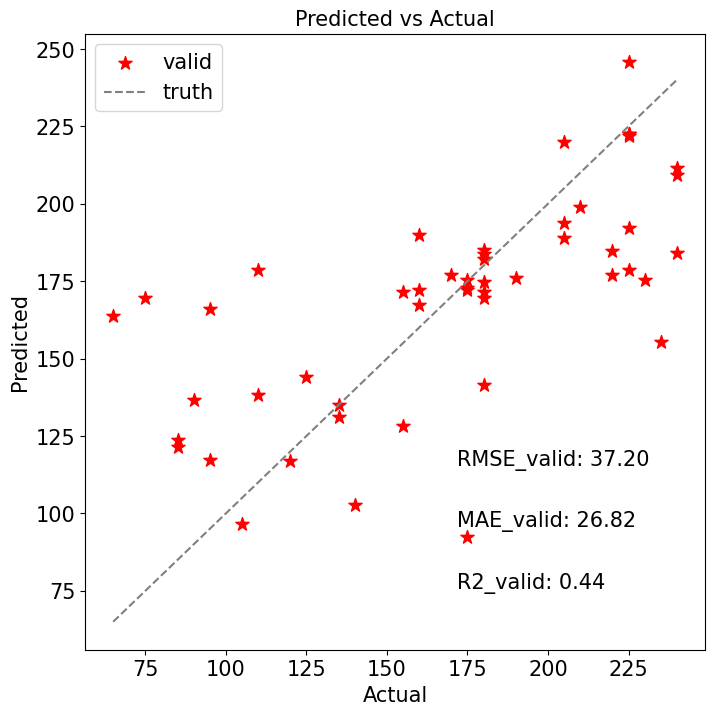

Ensemble 5/5, Seed: 9225
Performing LOO Cross Validation...


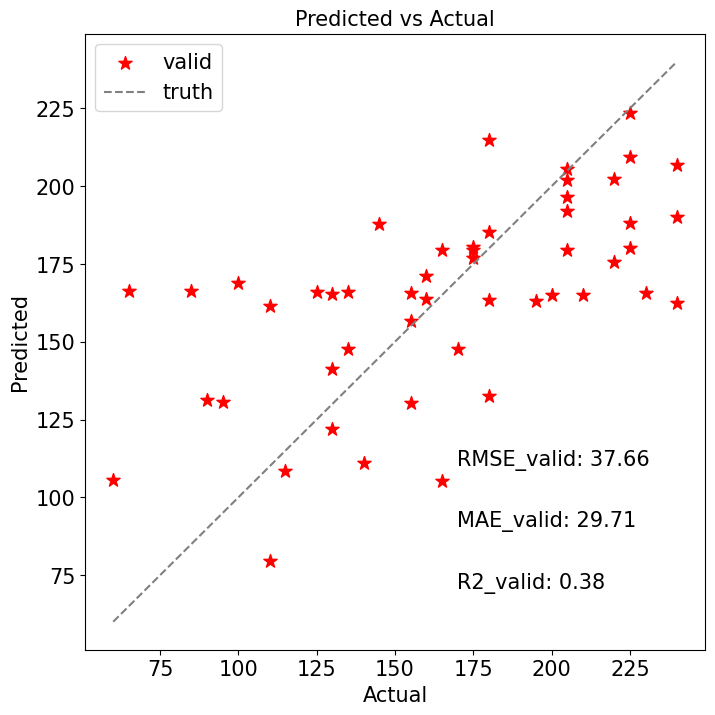

Optimization completed in 5.95 seconds.


In [76]:
X_all = data[x_columns].values
Y_all = data[y_columns].values.ravel()
model = GaussianProcessRegressor()
y_best_trend_list = optimize_experiment(
    model, X_all, Y_all, x_columns, y_columns, n_ensemble=5, n_exp_initial=50
)

## 結果の可視化

In [77]:
def optimize_experiment_random(X_all, Y_all, x_columns, y_columns, n_ensemble=5, n_exp_initial=50, iterations=-1):

    start_time = time.time()

    all_data_num = X_all.shape[0]
    np.random.seed(0)
    seed_list = [int(x) for x in np.random.randint(0, 10000, n_ensemble)]

    y_best_trend_list = []  # 各アンサンブルの結果を格納

    for ensemble_num, seed in enumerate(seed_list):
        print(f"Ensemble {ensemble_num + 1}/{n_ensemble}, Seed: {seed}")
        random.seed(seed)

        # 初期点の設定
        threshold = np.percentile(Y_all, 90)  # 上位10%の閾値
        top_10_percent_indices = np.where(Y_all >= threshold)[0]
        index_all_pool = list(range(all_data_num))  # 全インデックス
        index_under_pool = [i for i in index_all_pool if i not in top_10_percent_indices]
        index_observed = random.sample(index_under_pool, n_exp_initial)  # 初期点をランダムにサンプリング
        index_learn_pool = [i for i in index_all_pool if i not in index_observed]  # 未実験の候補リスト

        if iterations == -1:
            iterations = len(index_learn_pool)
        else:
            iterations = min(iterations, len(index_learn_pool))

        y_best_trend = []  # このアンサンブルでの最良値の推移

        for _ in range(iterations):
            # ランダムに次のサンプルを選択
            next_index = random.choice(index_learn_pool)
            index_observed.append(next_index)  # 実験済みに追加
            index_learn_pool.remove(next_index)  # 未実験リストから削除

            # 現時点での最良値を記録
            y_best_trend.append(np.max(Y_all[index_observed]))

        y_best_trend_list.append(y_best_trend)  # このアンサンブルの結果を保存

    print(f"Random search completed in {time.time() - start_time:.2f} seconds.")
    return y_best_trend_list


In [80]:
# ランダム探索の結果を取得
random_trend_list = optimize_experiment_random(
    X_all=X_all,
    Y_all=Y_all,
    x_columns=x_columns,
    y_columns=y_columns,
    n_ensemble=5,
    n_exp_initial=50,
    iterations=100
)

Ensemble 1/5, Seed: 2732
Ensemble 2/5, Seed: 9845
Ensemble 3/5, Seed: 3264
Ensemble 4/5, Seed: 4859
Ensemble 5/5, Seed: 9225
Random search completed in 0.04 seconds.


In [83]:
def compare_and_plot_trends(y_best_trend_list, random_trend_list):
    # EIとRandomの平均トレンドを計算
    ei_avg_trend = np.mean(y_best_trend_list, axis=0)
    random_avg_trend = np.mean(random_trend_list, axis=0)

    # プロット
    plt.figure(figsize=(8, 8))

    # 360ラインを黒の点線で追加
    plt.axhline(y=360, color="black", linestyle="--", linewidth=2)

    plt.plot(ei_avg_trend, label="EI_5ensemble", color="red", linewidth=2)
    plt.plot(random_avg_trend, label="Random_5ensemble", color="blue", linewidth=2)
    plt.xlabel("Trend")
    plt.ylabel("Best Value")
    plt.title(f"Trend of Best Value:{y_columns[0]}")
    plt.legend()
    plt.xlim(0, 100)
    plt.show()

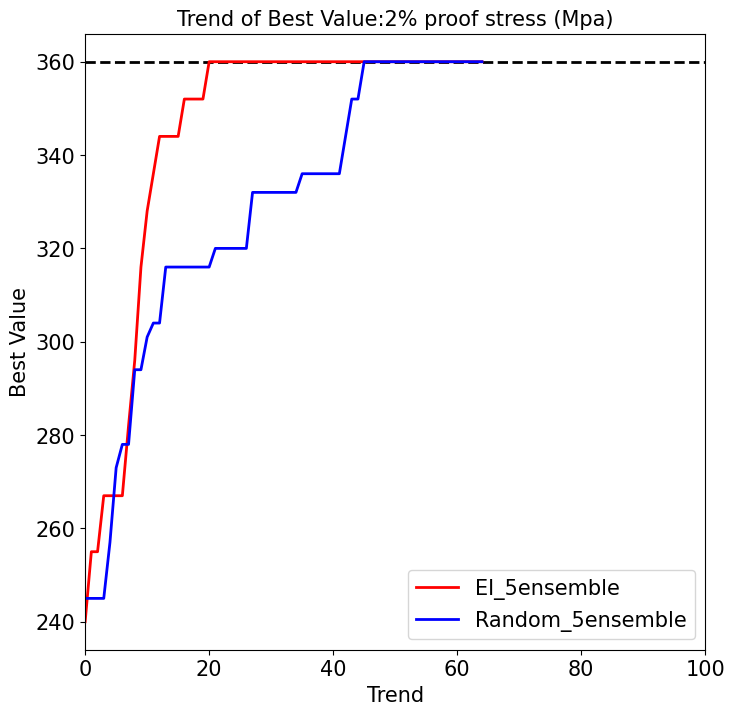

In [84]:
# 比較プロット
compare_and_plot_trends(y_best_trend_list, random_trend_list)

## カーネル変更による効果確認

Ensemble 1/5, Seed: 2732
Performing LOO Cross Validation...


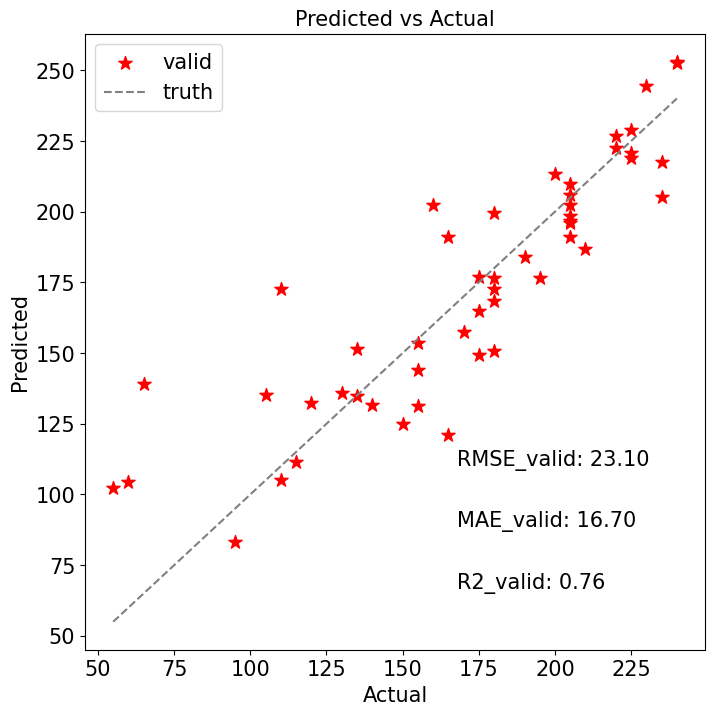

Ensemble 2/5, Seed: 9845
Performing LOO Cross Validation...


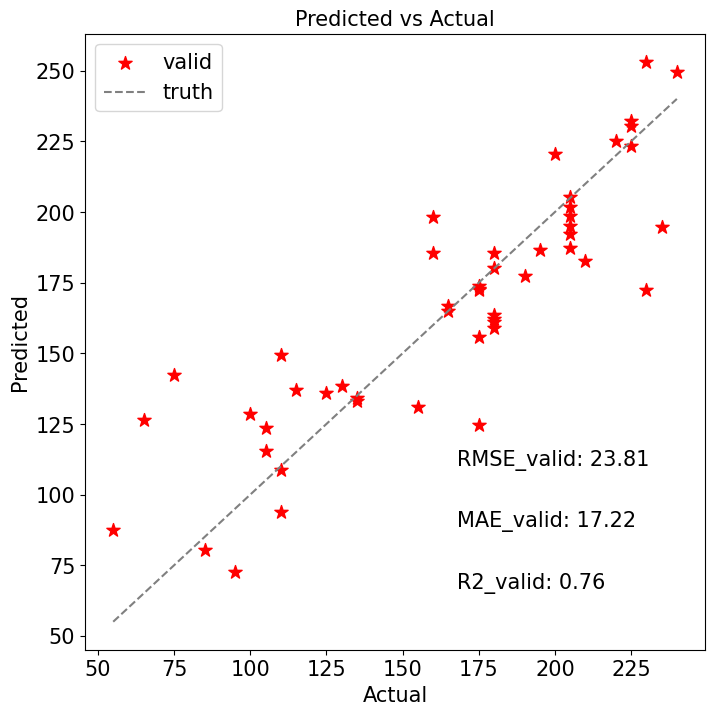

Ensemble 3/5, Seed: 3264
Performing LOO Cross Validation...


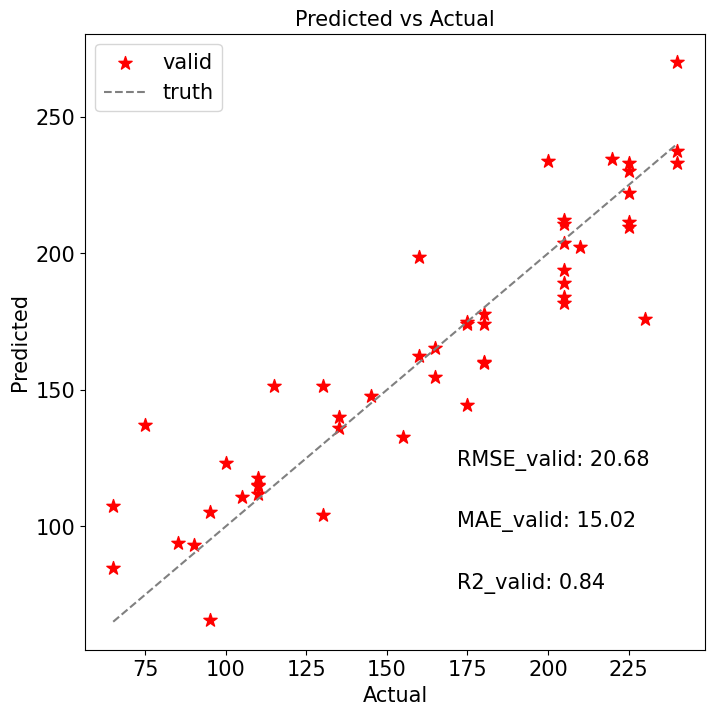

Ensemble 4/5, Seed: 4859
Performing LOO Cross Validation...


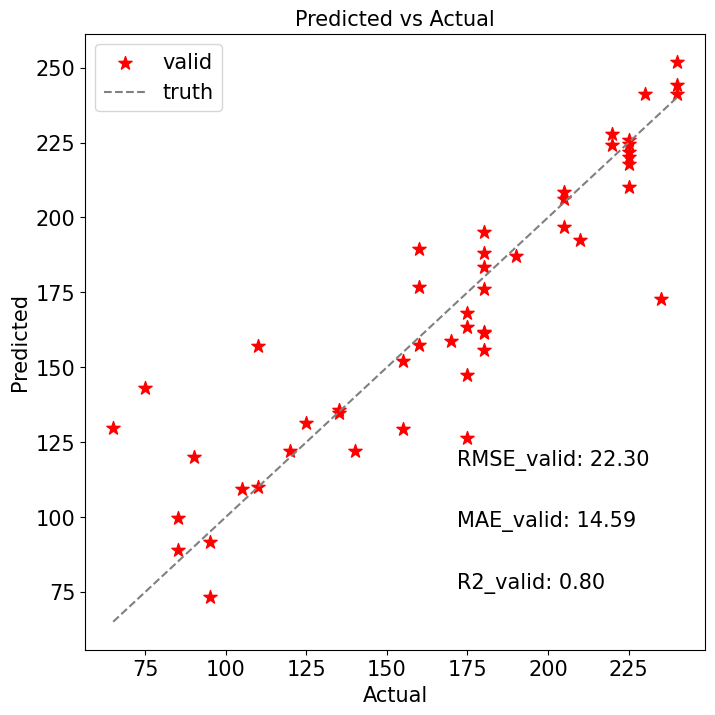

Ensemble 5/5, Seed: 9225
Performing LOO Cross Validation...


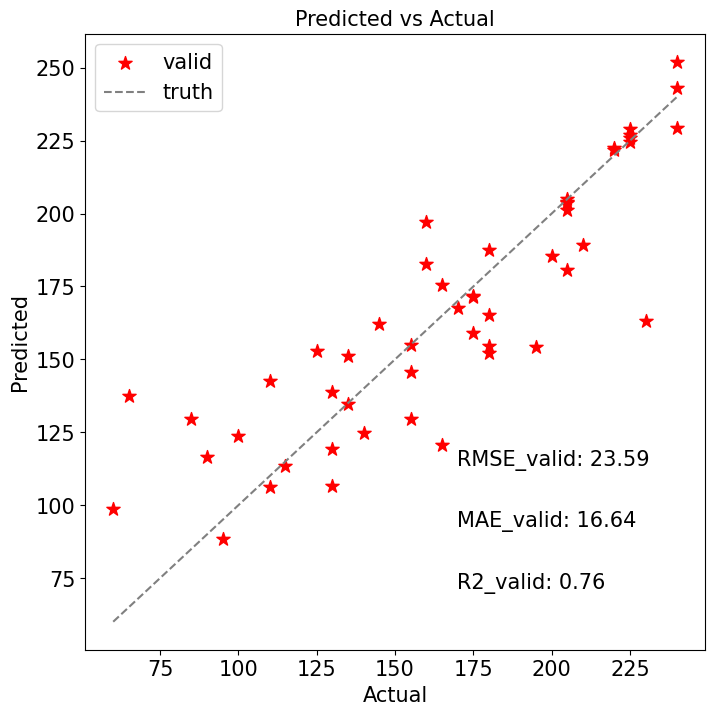

Optimization completed in 41.71 seconds.


In [85]:
model_kernel_change = GaussianProcessRegressor(ConstantKernel() * RBF() + WhiteKernel())
y_best_trend_list_kernel_change = optimize_experiment(
    model_kernel_change, X_all, Y_all, x_columns, y_columns, n_ensemble=5, n_exp_initial=50
)

In [93]:
def compare_and_plot_trends_kernel_change(y_best_trend_list, y_best_trend_list_kernel_change):
    # 平均トレンドを計算
    ei_avg_trend = np.mean(y_best_trend_list, axis=0)
    ei_avg_trend_kernel_change = np.mean(y_best_trend_list_kernel_change, axis=0)

    # プロット
    plt.figure(figsize=(8, 8))

    # 360ラインを黒の点線で追加
    plt.axhline(y=360, color="black", linestyle="--", linewidth=2)

    plt.plot(ei_avg_trend, label="default_5ensemble", color="red", linewidth=2)
    plt.plot(ei_avg_trend_kernel_change, label="kernel_change_5ensemble", color="blue", linewidth=2)
    plt.xlabel("Trend")
    plt.ylabel("Best Value")
    plt.title(f"Trend of Best Value:{y_columns[0]}")
    plt.legend()
    plt.xlim(0, 100)
    plt.tight_layout()
    plt.show()

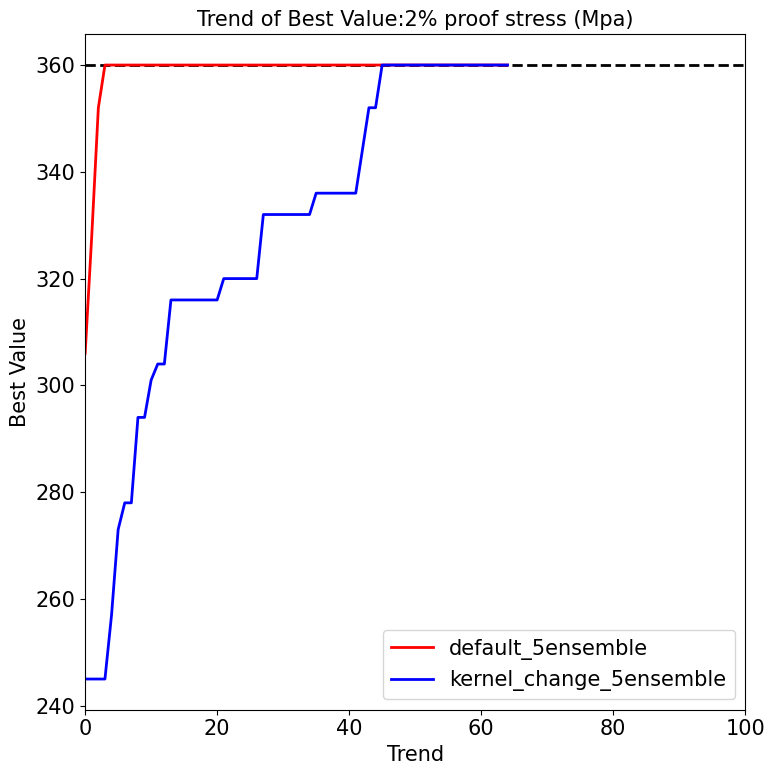

In [94]:
# 比較プロット
compare_and_plot_trends_kernel_change(y_best_trend_list_kernel_change, random_trend_list)